# Animal Counting using Traditional Image Processing

This notebook demonstrates how to count animals in images using basic image processing techniques without deep learning models.

In [1]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os

Loading images from Counting folder...
Counting\cat.jpg
Loaded: cat.jpg
Counting\mouse.jpg
Loaded: mouse.jpg
Counting\pair_boot.jpg
Loaded: pair_boot.jpg
Counting\rabbit.jpeg
Loaded: rabbit.jpeg
Counting\rabbit2.png
Loaded: rabbit2.png
Loaded 5 images from Counting folder.

Loading images from Finding folder...
Finding\1.jpg
Loaded: 1.jpg
Finding\2.jpg
Loaded: 2.jpg
Finding\3.jpg
Loaded: 3.jpg
Finding\boat_t.png
Loaded: boat_t.png
Finding\image.png
Loaded: image.png
Loaded 5 images from Finding folder.


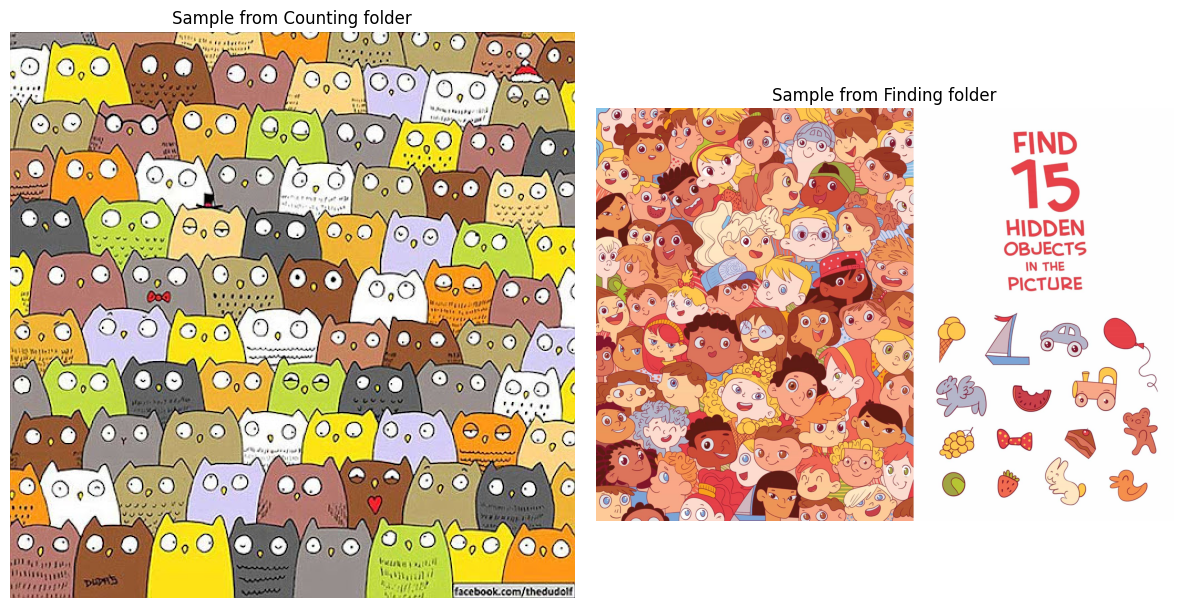

In [2]:
images_counting = []
images_finding = []

# Function to read all images from a folder
def read_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        # Check if the file is an image (you can add more extensions if needed)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(folder_path, filename)
            print(img_path)
            img = cv2.imread(img_path)
            if img is not None:
                # Convert from BGR to RGB for display purposes
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img_rgb)
                print(f"Loaded: {filename}")
            else:
                print(f"Failed to load: {filename}")
    return images

# Define paths to the Counting and Finding folders
counting_folder_path = "Counting"
finding_folder_path = "Finding"

# Load images from both folders
print("Loading images from Counting folder...")
images_counting = read_images_from_folder(counting_folder_path)
print(f"Loaded {len(images_counting)} images from Counting folder.\n")

print("Loading images from Finding folder...")
images_finding = read_images_from_folder(finding_folder_path)
print(f"Loaded {len(images_finding)} images from Finding folder.")

# Display a sample image from each folder if available
plt.figure(figsize=(12, 6))

if len(images_counting) > 0:
    plt.subplot(1, 2, 1)
    plt.imshow(images_counting[0])
    plt.title("Sample from Counting folder")
    plt.axis('off')

if len(images_finding) > 0:
    plt.subplot(1, 2, 2)
    plt.imshow(images_finding[0])
    plt.title("Sample from Finding folder")
    plt.axis('off')

plt.tight_layout()
plt.show()

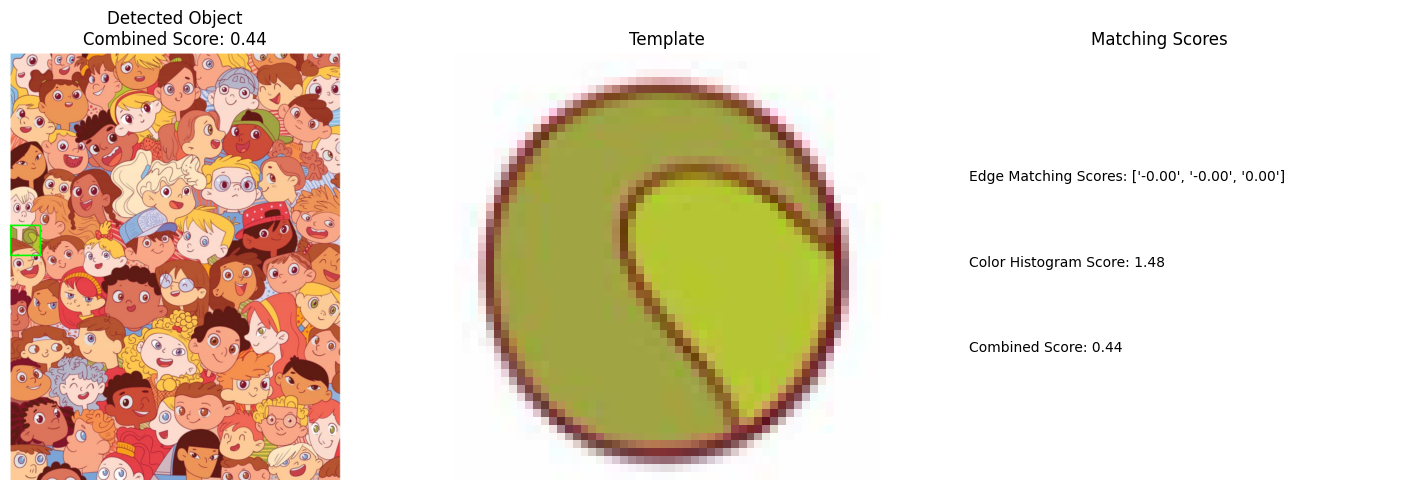

Match Location: (0, 310)
Edge Matching Scores: ['-0.00', '-0.00', '0.00']
Color Histogram Score: 1.48
Combined Score: 0.44


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def robust_edge_detection(image):
    """
    Perform robust edge detection with multiple methods.
    
    Args:
    image (numpy.ndarray): Grayscale input image
    
    Returns:
    list: List of edge-detected images
    """
    # Ensure input is grayscale
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Normalize to 8-bit unsigned integer
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Edge detection methods
    edges_methods = [
        cv2.Canny(gray, 50, 200),  # Canny edge detection
        cv2.Sobel(gray, cv2.CV_8U, 1, 0, ksize=3),  # Sobel X
        cv2.Sobel(gray, cv2.CV_8U, 0, 1, ksize=3)   # Sobel Y
    ]
    
    return edges_methods
def compute_multi_color_histograms(image):
    """
    Compute color histograms in multiple color spaces.
    
    Args:
    image (numpy.ndarray): Input image
    
    Returns:
    dict: Histograms in different color spaces
    """
    histograms = {}
    
    # HSV Color Space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_hist = cv2.calcHist([hsv_image], [0, 1], None, [180, 256], [0, 180, 0, 256])
    cv2.normalize(hsv_hist, hsv_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    histograms['hsv'] = hsv_hist
    
    # LAB Color Space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_hist = cv2.calcHist([lab_image], [1, 2], None, [256, 256], [0, 256, 0, 256])
    cv2.normalize(lab_hist, lab_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    histograms['lab'] = lab_hist
    
    return histograms

def compare_multi_color_histograms(hist1, hist2):
    """
    Compare multiple color histograms using different methods.
    
    Args:
    hist1 (dict): Histograms of first image
    hist2 (dict): Histograms of second image
    
    Returns:
    float: Combined color similarity score
    """
    methods = [
        cv2.HISTCMP_CORREL,  # Correlation
        cv2.HISTCMP_INTERSECT,  # Intersection
    ]
    
    total_score = 0
    for color_space, template_hist in hist1.items():
        roi_hist = hist2.get(color_space)
        if roi_hist is not None:
            # Compute scores for each method
            space_scores = [cv2.compareHist(template_hist, roi_hist, method) for method in methods]
            total_score += np.mean(space_scores)
    
    return total_score / len(hist1)

def advanced_template_matching(main_image, template):
    """
    Enhanced template matching with multiple edge detection techniques.
    
    Args:
    main_image (numpy.ndarray): Main image to search in
    template (numpy.ndarray): Template to find
    
    Returns:
    tuple: Best match location, edge scores, color score, and combined score
    """
    # Convert images to grayscale
    main_gray = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    # Perform robust edge detection
    main_edges = robust_edge_detection(main_gray)
    template_edges = robust_edge_detection(template_gray)
    
    # Prepare to store matching results
    edge_results = []
    
    # Perform template matching for each edge detection method
    for main_edge, template_edge in zip(main_edges, template_edges):
        # Ensure both are the same type and normalized
        main_edge = cv2.normalize(main_edge, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        template_edge = cv2.normalize(template_edge, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        # Perform template matching
        result = cv2.matchTemplate(main_edge, template_edge, cv2.TM_CCOEFF_NORMED)
        edge_results.append(result)
    
    # Compute color histograms
    template_hists = compute_multi_color_histograms(template)
    
    # Height and width of template
    h, w = template.shape[:2]
    
    # Initialize variables to track best match
    best_location = None
    edge_scores = []
    best_color_score = -np.inf
    best_combined_score = -np.inf
    
    # Combine edge results
    combined_edge_result = np.mean(edge_results, axis=0)
    
    # Iterate through all potential matches
    for y in range(combined_edge_result.shape[0]):
        for x in range(combined_edge_result.shape[1]):
            # Current edge matching score
            current_edge_score = combined_edge_result[y, x]
            
            # Extract region of interest from main image
            roi = main_image[y:y+h, x:x+w]
            
            # Skip if ROI is smaller than template
            if roi.shape[0] != h or roi.shape[1] != w:
                continue
            
            # Compute color histograms for ROI
            roi_hists = compute_multi_color_histograms(roi)
            
            # Compare color histograms
            color_score = compare_multi_color_histograms(template_hists, roi_hists)
            
            # Combine scores (you can adjust weights as needed)
            combined_score = 0.7 * current_edge_score + 0.3 * color_score
            
            # Update best match if current score is higher
            if combined_score > best_combined_score:
                best_location = (x, y)
                edge_scores = edge_results
                best_color_score = color_score
                best_combined_score = combined_score
    
    return best_location, edge_scores, best_color_score, best_combined_score

# Keep the rest of your existing functions (compute_multi_color_histograms, compare_multi_color_histograms)
# ... (include those functions from the original code)

def main():
    # Load images
    main_image = cv2.imread("Finding/image.png")
    template = cv2.imread("Template/find/tenis.png")
    
    # Perform advanced template matching
    match_location, edge_scores, color_score, combined_score = advanced_template_matching(main_image, template)
    
    # Height and width of template
    h, w = template.shape[:2]
    
    # Visualize results
    output_image = main_image.copy()
    cv2.rectangle(output_image, match_location, 
                  (match_location[0] + w, match_location[1] + h), 
                  (0, 255, 0), 2)
    
    # Convert BGR to RGB for Matplotlib
    output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
    template_rgb = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(output_image_rgb)
    plt.title(f"Detected Object\nCombined Score: {combined_score:.2f}")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(template_rgb)
    plt.title("Template")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.title("Matching Scores")
    plt.text(0.1, 0.7, f"Edge Matching Scores: {[f'{s:.2f}' for s in np.mean(edge_scores, axis=(1,2))]}", fontsize=10)
    plt.text(0.1, 0.5, f"Color Histogram Score: {color_score:.2f}", fontsize=10)
    plt.text(0.1, 0.3, f"Combined Score: {combined_score:.2f}", fontsize=10)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Match Location: {match_location}")
    print(f"Edge Matching Scores: {[f'{s:.2f}' for s in np.mean(edge_scores, axis=(1,2))]}")
    print(f"Color Histogram Score: {color_score:.2f}")
    print(f"Combined Score: {combined_score:.2f}")

if __name__ == "__main__":
    main()


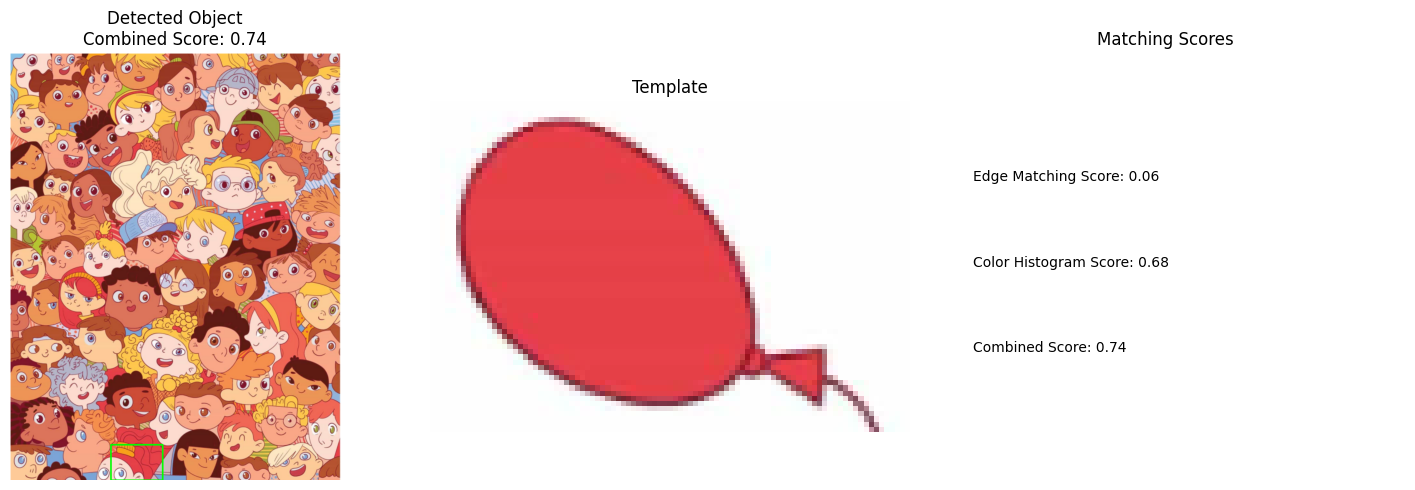

Match Location: (181, 705)
Edge Matching Score: 0.06
Color Histogram Score: 0.68
Combined Score: 0.74


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_color_histogram(image):
    """
    Compute color histogram for the given image.
    
    Args:
    image (numpy.ndarray): Input image
    
    Returns:
    numpy.ndarray: Normalized color histogram
    """
    # Convert to HSV color space for more robust color matching
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Compute histogram
    hist = cv2.calcHist([hsv_image], [0, 1], None, [180, 256], [0, 180, 0, 256])
    
    # Normalize the histogram
    cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    
    return hist

def compare_color_histograms(hist1, hist2):
    """
    Compare two color histograms using multiple methods.
    
    Args:
    hist1 (numpy.ndarray): First histogram
    hist2 (numpy.ndarray): Second histogram
    
    Returns:
    float: Averaged histogram comparison score
    """
    # Use multiple comparison methods
    methods = [
        cv2.HISTCMP_CORREL,  # Correlation
        cv2.HISTCMP_INTERSECT,  # Intersection
    ]
    
    scores = [cv2.compareHist(hist1, hist2, method) for method in methods]
    return np.mean(scores)

def comprehensive_template_matching(main_image, template):
    """
    Find the best template match by evaluating multiple locations.
    
    Args:
    main_image (numpy.ndarray): Main image to search in
    template (numpy.ndarray): Template to find
    
    Returns:
    tuple: Best match location, edge score, color score, and combined score
    """
    # Convert images to grayscale for edge detection
    main_gray = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    # Apply Canny edge detection
    main_edges = cv2.Canny(main_gray, 50, 200)
    template_edges = cv2.Canny(template_gray, 50, 200)
    
    # Perform template matching on edges
    edge_result = cv2.matchTemplate(main_edges, template_edges, cv2.TM_CCOEFF_NORMED)
    
    # Compute color histograms for template
    template_hist = compute_color_histogram(template)
    
    # Height and width of template
    h, w = template.shape[:2]
    
    # Initialize variables to track best match
    best_location = None
    best_edge_score = -np.inf
    best_color_score = -np.inf
    best_combined_score = -np.inf
    
    # Iterate through all potential matches
    for y in range(edge_result.shape[0]):
        for x in range(edge_result.shape[1]):
            # Current edge matching score
            current_edge_score = edge_result[y, x]
            
            # Extract region of interest from main image
            roi = main_image[y:y+h, x:x+w]
            
            # Skip if ROI is smaller than template
            if roi.shape[0] != h or roi.shape[1] != w:
                continue
            
            # Compute color histogram for ROI
            roi_hist = compute_color_histogram(roi)
            
            # Compare color histograms
            color_score = compare_color_histograms(template_hist, roi_hist)
            
            # Combine scores (you can adjust weights as needed)
            combined_score = current_edge_score + color_score
            
            # Update best match if current score is higher
            if combined_score > best_combined_score:
                best_location = (x, y)
                best_edge_score = current_edge_score
                best_color_score = color_score
                best_combined_score = combined_score
    
    return best_location, best_edge_score, best_color_score, best_combined_score

# Load images
main_image = cv2.imread("Finding/image.png")
template = cv2.imread("Template/find/baloon.png")

# Perform comprehensive template matching
match_location, edge_score, color_score, combined_score = comprehensive_template_matching(main_image, template)

# Height and width of template
h, w = template.shape[:2]

# Visualize results
# Draw rectangle on the matched location
output_image = main_image.copy()
cv2.rectangle(output_image, match_location, 
              (match_location[0] + w, match_location[1] + h), 
              (0, 255, 0), 2)

# Convert BGR to RGB for Matplotlib
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
template_rgb = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(output_image_rgb)
plt.title(f"Detected Object\nCombined Score: {combined_score:.2f}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(template_rgb)
plt.title("Template")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Matching Scores")
plt.text(0.1, 0.7, f"Edge Matching Score: {edge_score:.2f}", fontsize=10)
plt.text(0.1, 0.5, f"Color Histogram Score: {color_score:.2f}", fontsize=10)
plt.text(0.1, 0.3, f"Combined Score: {combined_score:.2f}", fontsize=10)
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Match Location: {match_location}")
print(f"Edge Matching Score: {edge_score:.2f}")
print(f"Color Histogram Score: {color_score:.2f}")
print(f"Combined Score: {combined_score:.2f}")


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_multi_color_histograms(image):
    """
    Compute color histograms in multiple color spaces.
    
    Args:
    image (numpy.ndarray): Input image
    
    Returns:
    dict: Histograms in different color spaces
    """
    histograms = {}
    
    # HSV Color Space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_hist = cv2.calcHist([hsv_image], [0, 1], None, [180, 256], [0, 180, 0, 256])
    cv2.normalize(hsv_hist, hsv_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    histograms['hsv'] = hsv_hist
    
    # LAB Color Space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_hist = cv2.calcHist([lab_image], [1, 2], None, [256, 256], [0, 256, 0, 256])
    cv2.normalize(lab_hist, lab_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    histograms['lab'] = lab_hist
    
    return histograms

def compare_multi_color_histograms(hist1, hist2):
    """
    Compare multiple color histograms using different methods.
    
    Args:
    hist1 (dict): Histograms of first image
    hist2 (dict): Histograms of second image
    
    Returns:
    float: Combined color similarity score
    """
    methods = [
        cv2.HISTCMP_CORREL,  # Correlation
        cv2.HISTCMP_INTERSECT,  # Intersection
    ]
    
    total_score = 0
    for color_space, template_hist in hist1.items():
        roi_hist = hist2.get(color_space)
        if roi_hist is not None:
            # Compute scores for each method
            space_scores = [cv2.compareHist(template_hist, roi_hist, method) for method in methods]
            total_score += np.mean(space_scores)
    
    return total_score / len(hist1)

def advanced_template_matching(main_image, template):
    """
    Enhanced template matching with multiple feature extraction.
    
    Args:
    main_image (numpy.ndarray): Main image to search in
    template (numpy.ndarray): Template to find
    
    Returns:
    tuple: Best match location, edge score, color score, and combined score
    """
    # Convert images to grayscale for edge detection
    main_gray = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    # Apply multiple edge detection methods
    main_edges_canny = cv2.Canny(main_gray, 50, 200)
    main_edges_sobel_x = cv2.Sobel(main_gray, cv2.CV_64F, 1, 0, ksize=3)
    main_edges_sobel_y = cv2.Sobel(main_gray, cv2.CV_64F, 0, 1, ksize=3)
    
    template_edges_canny = cv2.Canny(template_gray, 50, 200)
    template_edges_sobel_x = cv2.Sobel(template_gray, cv2.CV_64F, 1, 0, ksize=3)
    template_edges_sobel_y = cv2.Sobel(template_gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Perform template matching on different edge representations
    edge_results = [
        cv2.matchTemplate(main_edges_canny, template_edges_canny, cv2.TM_CCOEFF_NORMED),
        cv2.matchTemplate(main_edges_sobel_x, template_edges_sobel_x, cv2.TM_CCOEFF_NORMED),
        cv2.matchTemplate(main_edges_sobel_y, template_edges_sobel_y, cv2.TM_CCOEFF_NORMED)
    ]
    
    # Compute color histograms
    template_hists = compute_multi_color_histograms(template)
    
    # Height and width of template
    h, w = template.shape[:2]
    
    # Initialize variables to track best match
    best_location = None
    best_edge_score = -np.inf
    best_color_score = -np.inf
    best_combined_score = -np.inf
    
    # Combine edge results
    combined_edge_result = np.mean(edge_results, axis=0)
    
    # Iterate through all potential matches
    for y in range(combined_edge_result.shape[0]):
        for x in range(combined_edge_result.shape[1]):
            # Current edge matching score
            current_edge_score = combined_edge_result[y, x]
            
            # Extract region of interest from main image
            roi = main_image[y:y+h, x:x+w]
            
            # Skip if ROI is smaller than template
            if roi.shape[0] != h or roi.shape[1] != w:
                continue
            
            # Compute color histograms for ROI
            roi_hists = compute_multi_color_histograms(roi)
            
            # Compare color histograms
            color_score = compare_multi_color_histograms(template_hists, roi_hists)
            
            # Combine scores (you can adjust weights as needed)
            combined_score = 0.7 * current_edge_score + 0.3 * color_score
            
            # Update best match if current score is higher
            if combined_score > best_combined_score:
                best_location = (x, y)
                best_edge_score = current_edge_score
                best_color_score = color_score
                best_combined_score = combined_score
    
    return best_location, best_edge_score, best_color_score, best_combined_score

# Load images
main_image = cv2.imread("Finding/image.png")
template = cv2.imread("Template/find/duck.png")

# Perform advanced template matching
match_location, edge_score, color_score, combined_score = advanced_template_matching(main_image, template)

# Height and width of template
h, w = template.shape[:2]

# Visualize results
# Draw rectangle on the matched location
output_image = main_image.copy()
cv2.rectangle(output_image, match_location, 
              (match_location[0] + w, match_location[1] + h), 
              (0, 255, 0), 2)

# Convert BGR to RGB for Matplotlib
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
template_rgb = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(output_image_rgb)
plt.title(f"Detected Object\nCombined Score: {combined_score:.2f}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(template_rgb)
plt.title("Template")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Matching Scores")
plt.text(0.1, 0.7, f"Edge Matching Score: {edge_score:.2f}", fontsize=10)
plt.text(0.1, 0.5, f"Color Histogram Score: {color_score:.2f}", fontsize=10)
plt.text(0.1, 0.3, f"Combined Score: {combined_score:.2f}", fontsize=10)
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Match Location: {match_location}")
print(f"Edge Matching Score: {edge_score:.2f}")
print(f"Color Histogram Score: {color_score:.2f}")
print(f"Combined Score: {combined_score:.2f}")